In [1]:
import os
import sys
import time
import yaml
import pandas as pd
import numpy as np
import re

with open('../../config.local.yaml', 'r') as f:
    local_config = yaml.safe_load(f)

LOCAL_PATH = local_config['LOCAL_PATH']

sys.path.append(os.path.join(LOCAL_PATH, "src/python"))

import data_tools as dt
import writing_tools as wt
from utils import parse_casenum
from llm import get_embeddings

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from IPython.core.display import HTML
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 11

os.environ['LOKY_MAX_CPU_COUNT'] = '1' # because of windows core count warning

rng = np.random.default_rng(12898)

N_CLUSTERS = 3
N_COMPONENTS = 10


In [2]:
dfa = dt.get_agenda_items(verbose=False)

In [3]:
# Get the agenda item embeddings
texts = dfa['project_summary'].tolist()
embeddings = get_embeddings(texts)

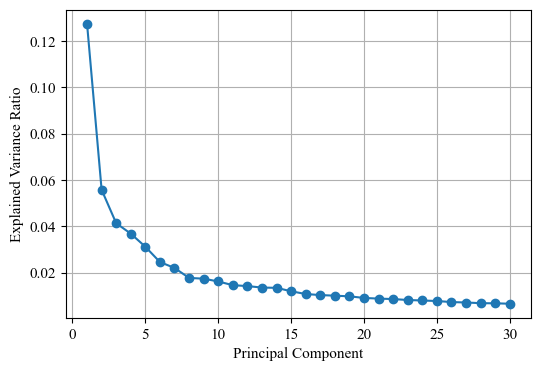

In [4]:
# PCA scree plot
pca = PCA()
pca.fit(embeddings)
explained_variance = pca.explained_variance_ratio_[0:30]
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
#plt.title('Scree Plot of PCA Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid()
filename = os.path.join(LOCAL_PATH, 'figures', 'fig_scree_plot.pdf')
plt.savefig(filename, bbox_inches='tight')
plt.show()


In [5]:
# Reduce embeddings to 10 dimensions
pca = PCA(n_components=N_COMPONENTS)
embeddings_reduced = pca.fit_transform(embeddings)

In [6]:
# Cluster into 3 clusters using kmeans
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
kmeans.fit(embeddings_reduced)
dfa['cluster'] = kmeans.labels_
dfa['cluster'].value_counts()

cluster
0    543
1    118
2     69
Name: count, dtype: int64

In [7]:
# Show random examples from each cluster
for cluster in dfa['cluster'].unique():
    print(f"Cluster {cluster}:")
    cluster_items = dfa[dfa['cluster'] == cluster]
    sample_items = cluster_items.sample(3)
    for idx, row in sample_items.iterrows():
        print("---")
        print(row['project_summary'])
    print("======")
    print("")

Cluster 0:
---
The project involves maintaining an existing 2,573-square foot commercial building and demolishing other existing structures to construct a new residential-commercial building. This new building will include 104 dwelling units, with 11 designated for Extremely Low Income residents, and five levels of residential space above 8,000 square feet of ground floor retail and restaurant space. The project will provide 101 vehicle parking spaces and 93 bicycle parking spaces, totaling 109,403 square feet with a Floor Area Ratio (FAR) of 3.83:1. Two retaining walls, 10 and 20 feet in height, are also proposed.
---
The proposed project involves the construction of a four-story, 45-foot and five-inch tall residential building with 102 dwelling units, including 12 units designated for Very Low Income households. The building will have a floor area of approximately 83,158 square feet and a Floor Area Ratio (FAR) of 2.65:1. It will provide 127 parking spaces across two subterranean lev

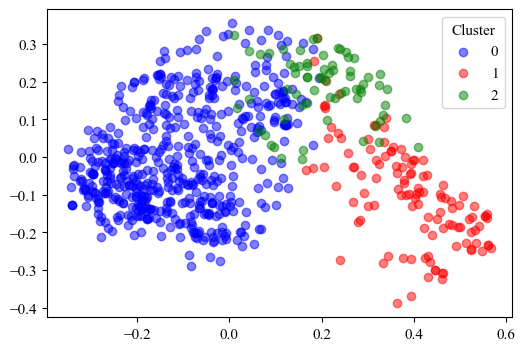

In [8]:
# Scatter plot colored by cluster
plt.figure(figsize=(6, 4))
colormap = ['blue', 'red', 'green']
for i in range(N_CLUSTERS):
    myx = embeddings_reduced[kmeans.labels_ == i, 0]
    myy = embeddings_reduced[kmeans.labels_ == i, 1]
    plt.scatter(myx, myy, alpha=0.5, label=f'{i}', color=colormap[i])
plt.legend(title='Cluster')
filename = os.path.join(LOCAL_PATH, 'figures', 'fig_clusters.pdf')
plt.savefig(filename, bbox_inches='tight')
plt.show()

In [9]:
df_new = dfa[['date', 'item_no', 'title', 'project_summary', 'cluster']].copy()
new_cols = [f'd{k}' for k in range(embeddings_reduced.shape[1])]
df_new = pd.concat([df_new, pd.DataFrame(embeddings_reduced, columns=new_cols)], axis=1)
df_new.to_csv(
    os.path.join(LOCAL_PATH, 'intermediate_data/cpc', 'agenda_item_with_embeddings.csv'),
    index=False,
    header=True
)

In [10]:
# create a dataframe with the cluster centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=new_cols)
centroids['cluster'] = range(N_CLUSTERS)
centroids = centroids[['cluster'] + [col for col in centroids.columns if col != 'cluster']]
centroids.to_csv(
    os.path.join(LOCAL_PATH, 'intermediate_data/cpc', 'cluster_centroids.csv'),
    index=False,
    header=True
)